<a href="https://colab.research.google.com/github/ariang/fs23ads/blob/main/NN_for_image_recognition_P1_(28_03_2023).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to computer vision with Keras and TensorFlow

In [ ]:
# To have plots displayed inline, directly below the code cell that produced it.
%matplotlib inline

To understand the fundamentals of deep learning (for computer vision), we will walk through the basic steps of building two toy models for classifying handwritten numbers with accuracies surpassing 95%. 

The first model will be a basic fully-connected neural network, and the second model (next Colab) will be a deeper network that introduces the concepts of convolution and pooling.


## The data

Our goal is to construct and train an artificial neural network on thousands of images of handwritten digits so that it may successfully identify others when presented. 

To train and test our model, we will use the famous [MNIST database](http://yann.lecun.com/exdb/mnist/), contaning 60k images for training and 10k for validation. Each image is 28 x 28 pixels.


<img src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png" >

<sub><sup>Source: Josef Steppan (2017), Wikipedia, CC BY-SA 4.0.<sub><sup>

## Necessary Python Libraries

Let us load what we need, including the data, which we can find in *keras*.

In [ ]:
import numpy as np                   
import matplotlib.pyplot as plt      
import random                        # random number generators

from keras.datasets import mnist     # MNIST dataset is included in Keras
from keras.models import Sequential  # Sequential models in Keras

from keras.layers.core import Dense, Dropout, Activation # Types of layers to be used in our model
from keras.utils import np_utils                         # NumPy related tools

## Loading Training Data

There is no need to look for the MNIST dataset elsewhere, as we can find it within *keras*.

In [ ]:
# Let us load the data (training and validation/test)
(X_train, Y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


To have an idea of the data, we can plot some sample images from the training set directly into this notebook.

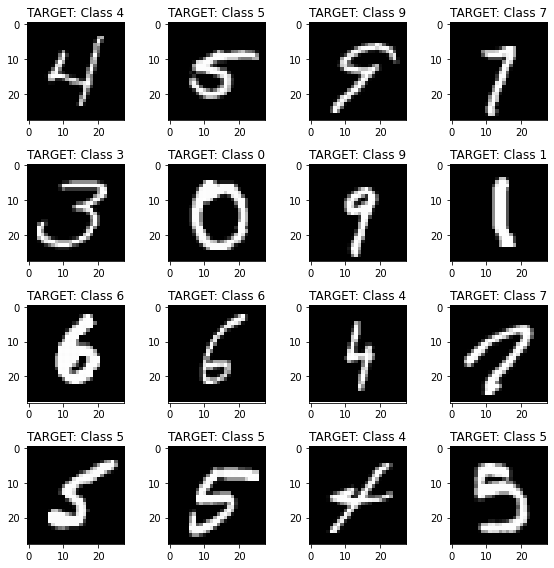

In [ ]:
plt.rcParams['figure.figsize'] = (8,8) # to resize the single pics for display

for i in range(16):
    plt.subplot(4,4,i+1)
    num = random.randint(0, len(X_train)) # at every run a different sample
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title("TARGET: Class {}".format(Y_train[num]))
    
plt.tight_layout()

Therefore the target is a categorical variable (0 to 9), while the features relate to the pixels.

But how does our machine recognize each number in the gray scale above?

Let us have a look at the last digit in the picure above.

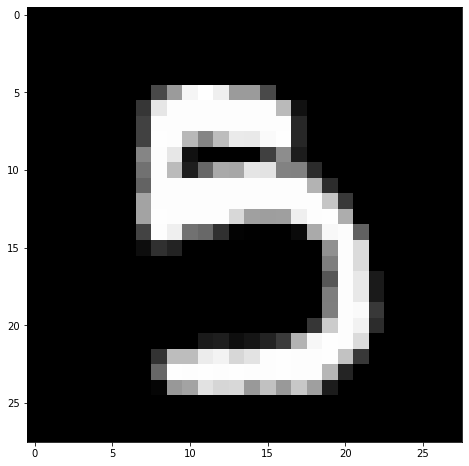

In [ ]:
plt.imshow(X_train[num], cmap='gray', interpolation='none')

 We will use a function we write ourselves.

In [ ]:
# just a little function for pretty printing a matrix
def matplotnum(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

# now print!        
matplotnum(X_train[num])

0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  0  0  
0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  0  0  
0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  0  0  
0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  0  0  
0  0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  0  0  
0  0  0  0  0  0  0    0   74  155  245  255  239  155  155   74    0    0    0    0    0    0   0  0  0  0  0  0  
0  0  0  0  0  0  0   54  230  253  253  253  253  253  253  253  186   17    0    0    0    0   0  0  0  0  0  0  
0  0  0  0  0  0  0   65  253  253  253  253  253  253  253  253  253   39    0    0    0    0   0  0  0  0  0  0  
0  0  0  0  0  0  0   65  254  253  184  133  189  234  233  250  254   

Each pixel is an 8-bit integer from 0-255. 0 is full black, while 255 is full white. 

This what we call a single-channel pixel, or monochrome.

## Transforming the inputs (flattening and rescaling)

Playing with 28 x 28 matrices is inefficient for our machines, looking at the manipulations we need in estimation. 

This is why we flatten each image, transforming a 28 x 28 matrix into a vector of length 784 (=28*28).

$$
\left[\begin{array}{ccc} 1 & 1 & 0 \\ 5 & 3 & 1\\ 0 & 0 & 2 \end{array} \right] \to \left[\begin{array}{c} 1 & 1 & 0 & 5 & 3 & 1 & 0 & 0 & 2 \end{array} \right]
$$

The next step is to rescale the input. As usual, we can choose between standardization and normalization. In this setting, all numbers are non-negative (shades of gray from 0 to 255), therefore the sign is not relevant (differently from the California Housing case). As a consequence, we normalize our data.

This implies removing the minimum from each value, and dividing by the range (i.e., max-min). Since the minimum is 0, we just have to divide each number by 255.



In [ ]:
X_train = X_train.reshape(60000, 784) # reshape 28 x 28 matrices into 60,000 784-length vectors.
X_test = X_test.reshape(10000, 784)  

X_train = X_train.astype('float32')   # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255  # normalize in [0,1] each value in the entire vector for each input                     
X_test /= 255

## Transforming the output (one-hot format)

We now modify the output using the so-called one-hot format (dummification in statistics).

Each target can attain a value between 0 and 9, depending on the digit it represents.

In the one-hot format, the digits from 0 to 9 are transformed as follows:

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
...
9 -> [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
```
This format is convenient, because it allows Python to provide its estimate very conveniently.

For instance, an image representing a 2 could be classified as follows:

```
[0, 0, 0.98, 0, 0, 0, 0, 0, 0, 0.02],
```
indicating that the value 2 is the most probable (98%).

In [ ]:
# Dummification
nb_classes = 10 # number of unique digits
Y_train = np_utils.to_categorical(Y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

# Time to build our network

<img src="https://zitaoshen.rbind.io/project/machine_learning/how-to-build-your-own-neural-net-from-the-scrach/featured.png" />

In [ ]:
# As usual, we start from the basic sequential model.
model = Sequential()

## The first hidden layer

When dealing with images, it is convenient to start with a large number of nodes in the first hidden layer. Usually, one starts with a large power of 2. 

Common values are $258=2^8$ and $512=2^9$.

In [ ]:
# We choose to start with 512 units in the first HL
model.add(Dense(512, input_shape=(784,))) 
# Recall that we have 784-long vectors. 

In [ ]:
# Now we choose the activation function. Let us go for the famous relu
model.add(Activation('relu'))

**Question for you:** what about using another activation function, like *tanh* or *sigmoid*? Would it make sense?

*Also check the exercise at the end of the notebook.*

In [ ]:
# Given the large number of units, it can be convenient to use dropout
# regularization, to avoid overfitting.
model.add(Dropout(0.2))

## Adding the second hidden layer

For the second layer, let us choose a smaller number of nodes, say half of 512.

Also here we play with relu and dropout.

In [ ]:
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.2))

## The Final Output Layer

In [ ]:
# The final layer needs to give 10 possible answers (digits from 0 to 9).
# Therefore its structure is pretty obvious.
model.add(Dense(10))

In [ ]:
# The "softmax" activation represents a probability distribution over k different possible outcomes.
# Its values are all non-negative and sum to 1 (like the probabilities over the
# vectors of the form [0, 0, 0.98, 0, 0, 0, 0, 0, 0, 0.02]).

model.add(Activation('softmax'))

The [softmax function](https://en.wikipedia.org/wiki/Softmax_function) is defined as $\sigma(\mathbf{z})_i = \frac{e^{z_i}}{\sum_{j=1}^K e^{z_j}}$, for $i=1,...,k$, where $k$ is the number of items in the set (for us $k=10$). It is a function converting a vector of k real numbers into a probability distribution of k possible outcomes. In statistics it is used in the multinomial (logistic) regression. In probability theory, the output of the softmax function can be used to represent a categorical distribution.

In [ ]:
# Summarize the built model

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                2

**Please notice:** even a simple network like ours has a very large number of parameters to be trained!

## Compiling the model

When compiling a model, Keras asks us to specify your **loss function** and your **optimizer**. 

The loss function we use is called *categorical cross-entropy*, which is well-suited for comparing two probability distributions.

Our predictions are probability distributions across ten different digits.

For instance, we are 98% confident an image is a 2, even if there is a 2% probability it is actually a 9. Almost surely we reject the idea it is a 0, or 1, or 3, etc.

The cross-entropy is a measure of how different your predicted distribution is from the target distribution. [Check Wikipedia for more info](https://en.wikipedia.org/wiki/Cross_entropy).

If $P$ and $Q$ are two discrete (possibly degenerate) probability mass functions (as in our case) on the same set $\mathcal{X}$ (for us [0,1,...,9]), then cross-entropy is computed as

$$
H(P,Q) = -\sum_{x\in\mathcal{X}} P(x)\, \log Q(x).
$$

The smaller the value $H(P,Q)$ the closer the two probability mass functions are.

In keras, this type of cross-entropy is called *categorical_crossentropy*, to distinguish it from the continuous case.

Recall that the optimizer helps determine how quickly the model learns through **gradient descent**. Also recall that the rate at which the impacts of the gradient are applied is called **learning rate** (and we can control it).


In [ ]:
# Let's use the Adam optimizer for learning
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Let us train!
Time to choose the batch size and the epochs.
We choose $2^7=128$ for the batch size, and $10$ for the epochs.


In [ ]:
model.fit(X_train, Y_train,
          batch_size=128, epochs=10,
          verbose=1)
# verbose is used to see the progress of the process ('auto', 0, 1, 2)

Epoch 1/10
469/469 [==============================] - 16s 29ms/step - loss: 0.2650 - accuracy: 0.9221
Epoch 2/10
469/469 [==============================] - 8s 18ms/step - loss: 0.1081 - accuracy: 0.9675
Epoch 3/10
469/469 [==============================] - 7s 15ms/step - loss: 0.0779 - accuracy: 0.9755
Epoch 4/10
469/469 [==============================] - 8s 18ms/step - loss: 0.0598 - accuracy: 0.9809
Epoch 5/10
469/469 [==============================] - 8s 18ms/step - loss: 0.0483 - accuracy: 0.9842
Epoch 6/10
469/469 [==============================] - 7s 15ms/step - loss: 0.0427 - accuracy: 0.9859
Epoch 7/10
469/469 [==============================] - 8s 18ms/step - loss: 0.0359 - accuracy: 0.9879
Epoch 8/10
469/469 [==============================] - 8s 16ms/step - loss: 0.0322 - accuracy: 0.9896
Epoch 9/10
469/469 [==============================] - 8s 17ms/step - loss: 0.0291 - accuracy: 0.9903
Epoch 10/10
469/469 [==============================] - 8s 18ms/step - loss: 0.0238 - accur

The two numbers, in order, represent the value of the loss function of the network on the training set, and the overall accuracy of the network on the training data. On the training data, results are flattering.

Notice that 469 is nothing but $\approx\frac{60000}{128}$.


## Evaluate Model's Accuracy on Test Data

How does our model generalize?

Let us check on the test data.

In [ ]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 2s 5ms/step - loss: 0.0691 - accuracy: 0.9820
Test score: 0.0691257193684578
Test accuracy: 0.9819999933242798


Not bad at all!

# Exercise for you: Experiment with the network!

* How does increasing the batch size to 8192 affect the training time and test accuracy?

* How about a batch size of 32?

* What about a different activation function?



In [ ]:
#@title Possible answers
#
# 1) The training speed increases, the difference in accuracy is not statistically
#    significant.
# 2) It takes definitely longer, again no major difference in accuracy. 
# 3) Some choices like tanh do not really make sense, given the supports.
#    Non-negative a.f. give similar results (to relu), but are more computationally
#    expensive.

# More about the output
With all statistical models, and networks are no exception, it is fundamental to have a look at the output (predictions). In particular, it is important to understand what works and what does not.


In [ ]:
# Let us extract the predictted classes
predicted_classes = np.argmax(model.predict(X_test), axis=-1)

# Check which items we correctly classified and which not.
correct_classes = np.nonzero(predicted_classes == y_test)[0]
incorrect_classes = np.nonzero(predicted_classes != y_test)[0]

print('Correct:', len(correct_classes)/10000)
print('Incorrect:', len(incorrect_classes)/10000)

313/313 [==============================] - 2s 5ms/step
Correct: 0.982
Incorrect: 0.018


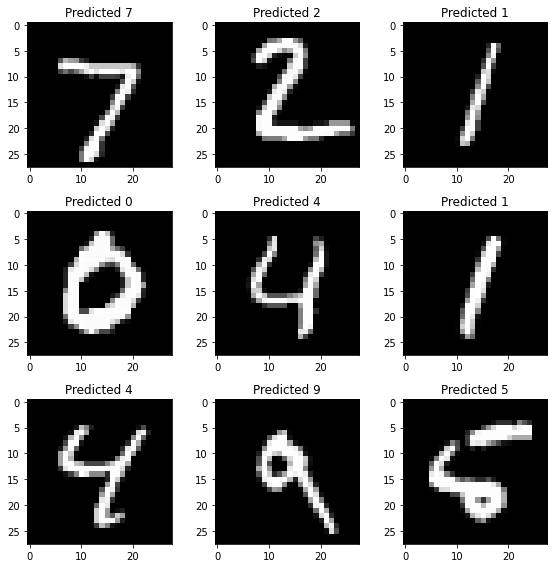

In [ ]:
#@title Correctly classified
plt.figure()
for i, correct in enumerate(correct_classes[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}".format(predicted_classes[correct]))
    
plt.tight_layout()
    

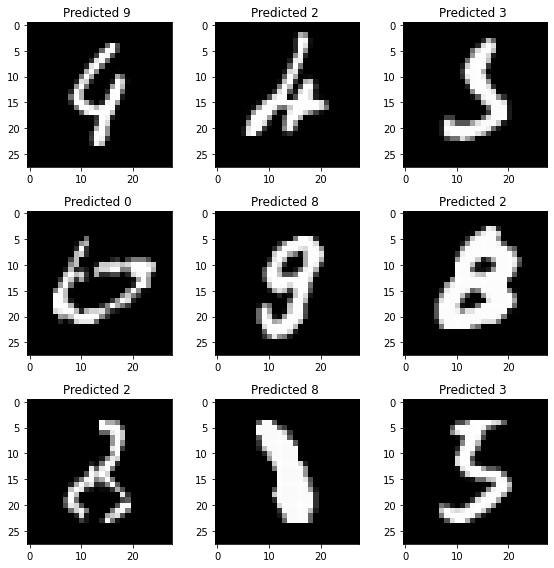

In [ ]:
#@title Incorrectly classified
plt.figure()
for i, incorrect in enumerate(incorrect_classes[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {} ".format(predicted_classes[incorrect]))
    
plt.tight_layout()

The lesson continues in the next Colab file.